In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.dm import DataModule2

dm = DataModule2(batch_size=4)
dm.setup()

train: 8689
test: 2773


In [3]:
s1, s2, labels = next(iter(dm.train_dataloader()))

s1.shape, s2.shape, s2.max(), s2.min()

(torch.Size([4, 12, 256, 256, 2]),
 torch.Size([4, 12, 256, 256, 6]),
 tensor(1.),
 tensor(0.))

In [8]:
from src.models.unet_ltae import UNetLTAE

hparams = {
	'encoder': 'resnet18',
	'pretrained': None, 
	'in_channels_s1': 2,
	'in_channels_s2': 6,
	'seq_len': 12,
	'n_head': 16
}

model = UNetLTAE(hparams).cuda()

outputs = model(s1.cuda(), s2.cuda())

outputs.shape

torch.Size([4, 256, 256])

In [9]:
import pytorch_lightning as pl

dm = DataModule2(batch_size=4)

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',
	'in_channels_s1': 2,
	'in_channels_s2': 6,
	'seq_len': 12,
	'optimizer': 'Adam',
	'n_head': 16,
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = UNetLTAE(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=300,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder1          | ResNetEncoder    | 11.2 M
1 | encoder2          | ResNetEncoder    | 11.2 M
2 | decoder           | UnetDecoder      | 3.2 M 
3 | segmentation_head | SegmentationHead | 145   
4 | ltae              | LTAE             | 1.3 M 
-------------------------------------------------------
26.7 M    Trainable params
25.6 K    Non-trainable params
26.8 M    Total params
53.541    Total estimated model params size (MB)


train: 8689
test: 2773


/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:471: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning off the training dataloader shuffling for you.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

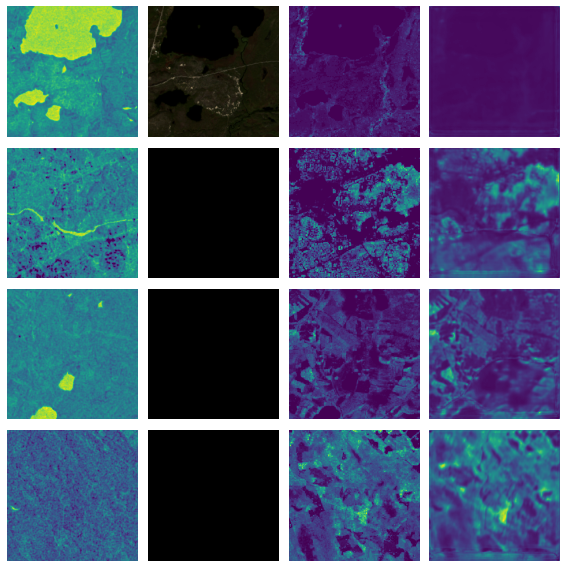

In [10]:
import matplotlib.pyplot as plt 

s1s, s2s, labels = next(iter(dm.train_dataloader(shuffle=False)))
preds = module.predict(s1s, s2s)
fig = plt.figure(figsize=(8, 2*dm.batch_size))
for i in range(dm.batch_size):
    ax = plt.subplot(dm.batch_size, 4, 4*i+1)
    ax.imshow(s1s[i][0][...,0])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+2)
    ax.imshow(s2s[i][0][...,:3])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+3)
    ax.imshow(labels[i])
    ax.axis('off')
    ax = plt.subplot(dm.batch_size, 4, 4*i+4)
    ax.imshow(preds[i])
    ax.axis('off')
plt.tight_layout()
plt.show()